## Project specification

This notebook implements and explores Echo State Networks (ESNs) to perform multi-step time series forecasting. Three distinct ESN approaches are introduced, each using different training strategies, and their performance is compared on benchmark datasets.

### Part 1: Standard Echo State Network (ESN)
This section covers a basic ESN implementation, employing a reservoir computing framework without feedback from the output and without leaky-integrator neurons. The model’s output weights are trained offline using regularized least squares (ridge regression). The goal is to forecast future points at multiple prediction horizons (*k* steps ahead). Experiments assess how well the ESN predicts synthetic and chaotic time series data, providing a baseline for subsequent comparisons.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import linalg
# make sure plots are displayed correctly on notebooks
%matplotlib inline

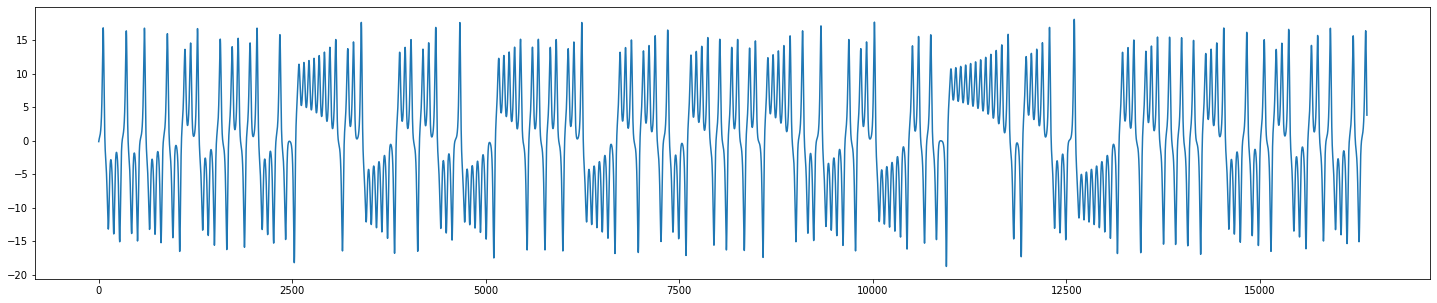

In [3]:
data = np.loadtxt('lorenz.txt')
plt.figure(figsize=[25, 5])
plt.plot(data)

The function (<span style='color:Blue'>randomWeights</span>) ramdomly initialize input weight matrix **Win** and recurrent weight matrix **W** <br/>

<span style='color:Orange'>**Description:**</span><br/>
Firstly, initialize **Win** and **W** followed by uniform distribution. Then compute the actual spectral radius, which is the maximal absolute eigenvalue of matrix **W**. Multiply **W** with **SpectualRadius** and divided by the computed spectral radius of W. Make the recurrent weight matrix sparser in some persentage by applying **sparsity** into the function.Finally output these two weight matrices.

In [4]:
def randomWeights(Nu, Nx, spectualRadius, sparsity):
    """
    The function (RandomWeights) ramdomly initialize input weight matrix Win and recurrent weight matrix W

    :param Nu: the input signal dimension, which equals to 1 in this case.
    :param Nx: the number of neurons in the reservoir.
    :param spectualRadius and sparsity are two hyper-parameters which can be tuned to generate a proper reservoir connection matrix W

    return:  input weight matrix (Win), recurrent weight matrix (W)
    """
    np.random.seed(0)
    Win = np.random.rand(Nx, 1 + Nu) - 0.5
    W = np.random.rand(Nx, Nx) - 0.5
    W = W * spectualRadius / np.max(np.abs(linalg.eigvals(W)))
    W[np.random.rand(*W.shape) < sparsity] = 0
    
    return Win, W

The function (<span style='color:Blue'>train</span>) applies basic Echo State Network (ESN).<br/>

<span style='color:Orange'>**Description:**</span><br/>Firstly, ramdomly generate **Win** and **W** matrices by function <span style='color:Blue'>RandomWeights</span>. Also initialize an empty matrix **X** to store vectors in each iteration and import **Y_target**, which is the signal targets (or labels) with **k** steps ahead. Secondly, in the range of training length, import the corresbonding training data as **u**, and compute the reservoir activation states **x** by the defination of ESN. In order to decrease the effect of the initial transient, the initial time steps of activations **x** could be discarded. Therefore, while the iteration is bigger than **init_len**, collect **x** and concatenate it with the input **u** and one bias term. Finally compute the linear readout weights **Wout** using the standard regularized least-square method.

In [5]:
def train(data, init_len, train_len, Nu, Nx, reg, k, spectualRadius, sparsity):
    """
    The function (train) applies basic Echo State Network (ESN).

    :param data: the input signal.
    :param init_len: the length of discarded data from the beginning.
    :param train_len: the length of training set including the length of initial transient.
    :param Nu: the input signal dimension and Nx is the number of neurons in the reservoir.
    :param Nx: the number of neurons in the reservoir.
    :param reg: the coefficient of regularization term.
    :param k: k step ahead of the forecasting task.
    :param spectualRadius and sparsity are two hyper-parameters which can be tuned to generate a proper reservoir connection matrix W.

    return: input weight matrix (Win), recurrent weight matrix (W), readout weight (Wout), 
            2-D array storing vectors in training iterations (X),the last computed vector of reservoir neuron activation x. 
    
    """
    Win, W = randomWeights(Nu, Nx, spectualRadius, sparsity)
    X = np.zeros((1 + Nu + Nx, train_len - init_len))
    Y_target = data[(init_len + k) : (train_len + k)]
    x = np.zeros((Nx, 1))
    for n in range(train_len):
        u = data[n]
        x = np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
        if n >= init_len:
            X[:, n - init_len] = np.vstack((1, u, x))[:, 0]

    Wout = Y_target.dot(X.T).dot(linalg.inv(X.dot(X.T) + reg * np.eye(1 + Nu + Nx)))
    
    return Win, W, Wout, X, x

The function (<span style='color:Blue'>test</span>) uses the trained **Wout** on new input data for computing prdictions **Y** by linear regression.<br/

<span style='color:Orange'>**Description:**</span><br/>Similar to the training process of ESN, this function examine the trained **Wout** with testing set and output the prdiction **Y**.


In [6]:
def test(data, train_len, test_len, Nu, Win, W, Wout, x):
    """
    The function uses the trained Wout on new input data for computing prdictions Y via linear regression.

    :param data: the input signal.
    :param train_len: the length of training set including the length of initial transient.
    :param test_len: the length of testing set.
    :param Nu: the input signal dimension and Nx is the number of neurons in the reservoir.
    :param Win: the input weight matrix.
    :param W: the recurrent weight matrix.
    :param Wout: the readout weight.
    :param x: the last computed vector of reservoir neuron activation.

    return: predicted results Y. 
    """
    Y = np.zeros((Nu, test_len))

    for t in range(test_len):
        u = data[train_len + t]
        x = np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
        y = np.dot(Wout, np.vstack((1, u, x)))
        Y[:, t] = y

    return Y


The function (<span style='color:Blue'>NRMSE</span>) compute the Normalized Root-Mean-Square Error (**NRMSE**).$$NRMSE =  \frac{\sqrt{<||t-z||^2>}}{var(t)}$$

In [7]:
def NRMSE(data, Y, k, train_len, test_len):
    """
    The function computes the Normalized Root-Mean-Square Error (NRMSE).

    :param data: the input signal.
    :param Y: predicted results.
    :param k: k step ahead of the forecasting task.
    :param train_len: the length of training set including the length of initial transient.
    :param test_len: the length of testing set.
    
    return: NRMSE score. 
    """
    t = data[(train_len + k): (train_len + test_len + k)]
    diff = t - Y
    nrmse = np.sqrt(diff.dot(diff.T)/len(t)) / np.var(t)
    
    return nrmse


- **Experiments on Lorenz system using ESN model**

In [8]:
# Load the data and Initialize hyper-parameters
data = np.loadtxt('lorenz.txt')
init_len = 100
train_len = 5000
test_len = 5000
Nx = 200
spectualRadius = 0.95
sparsity = 0
Nu = 1
reg = 1e-5

# Train ESN by  different k step ahead forecasting tasks
k0 = 0
Win, W, Wout, X, x = train(data, init_len, train_len, Nu, Nx, reg, k0, spectualRadius, sparsity)
Y0 = test(data, train_len, test_len, Nu, Win, W, Wout, x)
nrmse0 = NRMSE(data, Y0, k0, train_len, test_len)

k1 = 20
Win, W, Wout, X, x = train(data, init_len, train_len, Nu, Nx, reg, k1, spectualRadius, sparsity)
Y1 = test(data, train_len, test_len, Nu, Win, W, Wout, x)
nrmse1 = NRMSE(data, Y1, k1, train_len, test_len)

k2 = 50
Win, W, Wout, X, x = train(data, init_len, train_len, Nu, Nx, reg, k2, spectualRadius, sparsity)
Y2 = test(data, train_len, test_len, Nu, Win, W, Wout, x)
nrmse2 = NRMSE(data, Y2, k2, train_len, test_len)

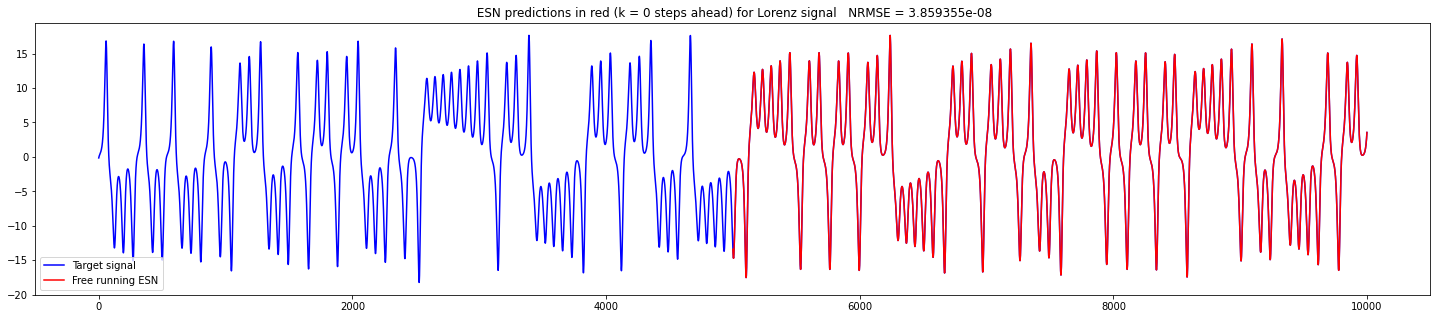

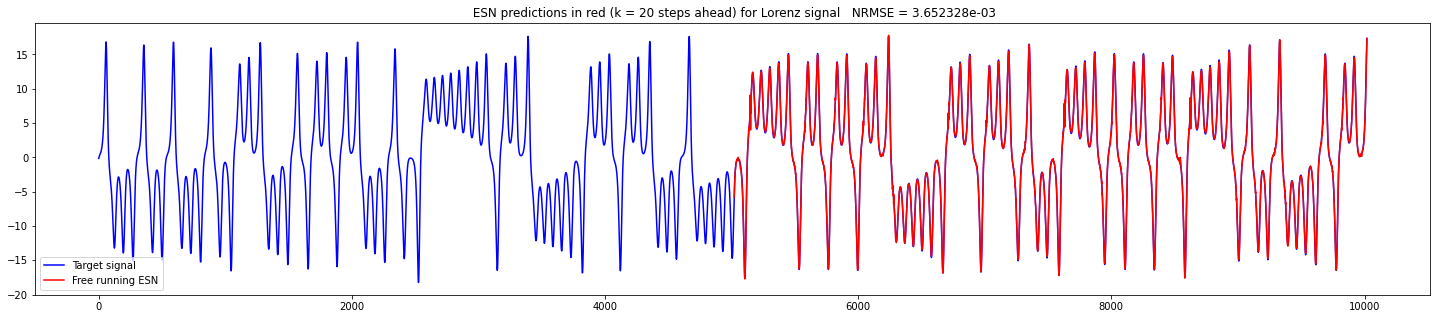

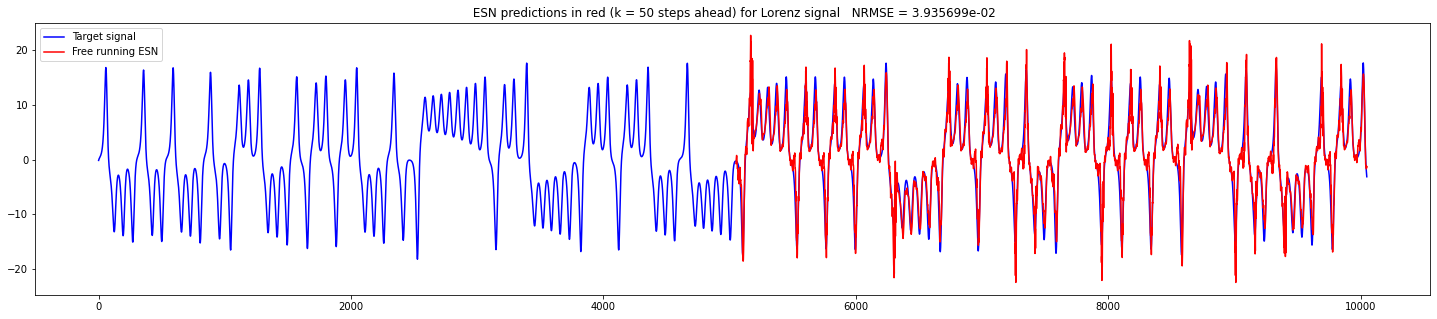

In [9]:
# Visualize the predicted results with original signal
# Plot1 
plt.figure(figsize=(25,5))
plt.plot(range(0, train_len + test_len+k0),data[0 :  train_len + test_len+k0], 'b')
plt.plot(range( train_len+k0, train_len + test_len+k0),Y0.T, 'r')
plt.title(' ESN predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' %(k0,nrmse0))
plt.legend(['Target signal', 'Free running ESN'])

# Plot2 
plt.figure(figsize=(25,5))
plt.plot(range(0, train_len + test_len+k1),data[0 :  train_len + test_len+k1], 'b')
plt.plot(range( train_len+k1, train_len + test_len+k1),Y1.T, 'r')
plt.title(' ESN predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' %(k1,nrmse1))
plt.legend(['Target signal', 'Free running ESN'])

# Plot3 
plt.figure(figsize=(25,5))
plt.plot(range(0, train_len + test_len+k2),data[0 :  train_len + test_len+k2], 'b')
plt.plot(range( train_len+k2, train_len + test_len+k2),Y2.T, 'r')
plt.title(' ESN predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' %(k2,nrmse2))
plt.legend(['Target signal', 'Free running ESN'])

<span style='color:Orange'>**Results description:**</span><br/>
In the experiment of ESN on lorenz system, I test **k** equal to 0, 20, 50 respectively, with other hyper-parameters keeping the same (I will discuss these hyper-parameters in the last section). As can see in the plots, the trained **Wout** is able to predict the unseen data accurately, and the Normalized Root-Mean-Square Errors remain low. The larger **k** value is, the accuracy of prediction is worse. 

- **Experiments on 2sin system using ESN model**

In [10]:
# Load the data and Initialize hyper-parameters
data = np.loadtxt('2sin.txt')
init_len = 100
train_len = 600
test_len = 600
Nx = 200
spectualRadius = 0.95
sparsity = 0
Nu = 1
reg = 1e-5

# Train ESN by  different k step ahead forecasting tasks
k0 = 0
Win, W, Wout, X, x = train(data, init_len, train_len, Nu, Nx, reg, k0, spectualRadius, sparsity)
Y0 = test(data, train_len, test_len, Nu, Win, W, Wout, x)
nrmse0 = NRMSE(data, Y0, k0, train_len, test_len)

k1 = 100
Win, W, Wout, X, x = train(data, init_len, train_len, Nu, Nx, reg, k1, spectualRadius, sparsity)
Y1 = test(data, train_len, test_len, Nu, Win, W, Wout, x)
nrmse1 = NRMSE(data, Y1, k1, train_len, test_len)

k2 = 500
Win, W, Wout, X, x = train(data, init_len, train_len, Nu, Nx, reg, k2, spectualRadius, sparsity)
Y2 = test(data, train_len, test_len, Nu, Win, W, Wout, x)
nrmse2 = NRMSE(data, Y2, k2, train_len, test_len)

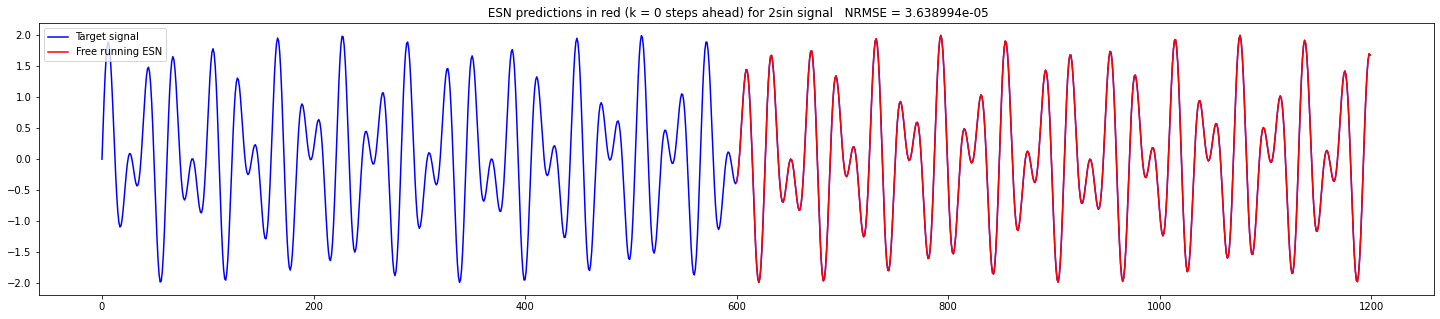

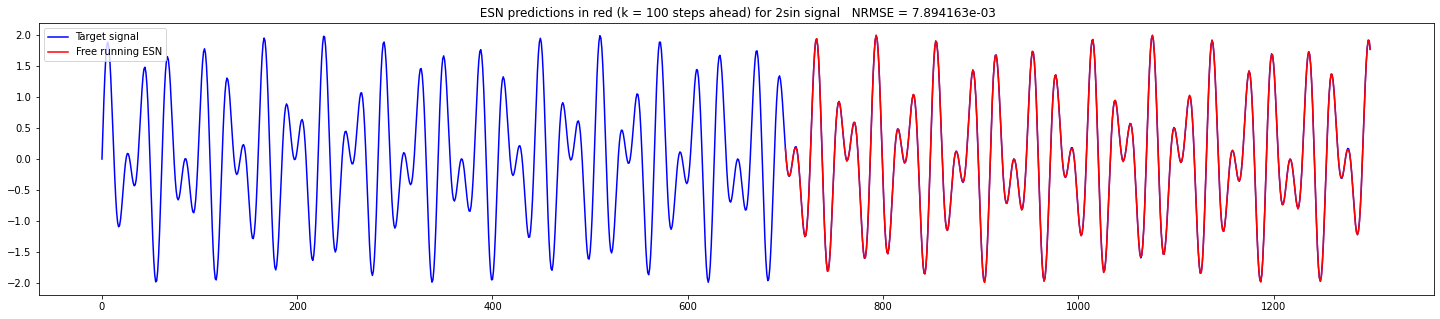

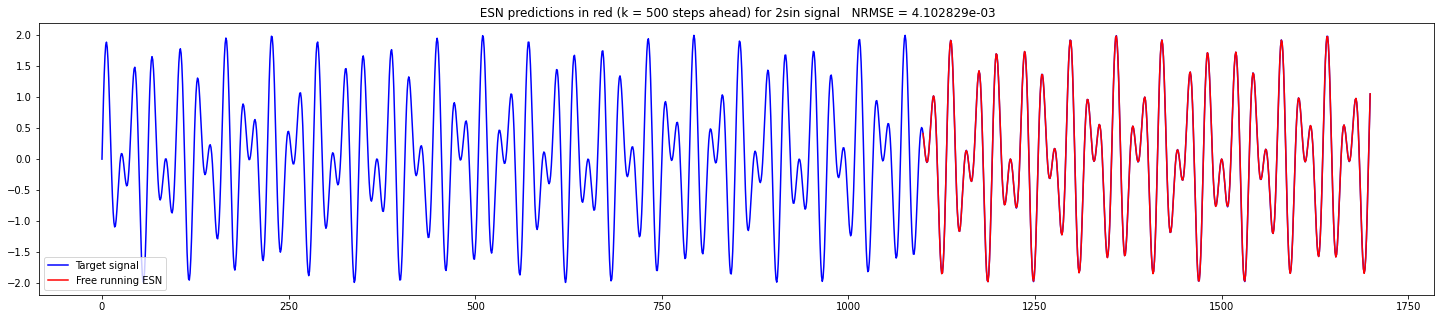

In [11]:
# Visualize the predicted results with original signal
# Plot1
plt.figure(figsize=(25,5))
plt.plot(range(0, train_len + test_len+k0),data[0 :  train_len + test_len+k0], 'b')
plt.plot(range( train_len+k0, train_len + test_len+k0),Y0.T, 'r')
plt.title(' ESN predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k0,nrmse0))
plt.legend(['Target signal', 'Free running ESN'])

# Plot2
plt.figure(figsize=(25,5))
plt.plot(range(0, train_len + test_len+k1),data[0 :  train_len + test_len+k1], 'b')
plt.plot(range( train_len+k1, train_len + test_len+k1),Y1.T, 'r')
plt.title(' ESN predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k1,nrmse1))
plt.legend(['Target signal', 'Free running ESN'])

# Plot3
plt.figure(figsize=(25,5))
plt.plot(range(0, train_len + test_len+k2),data[0 :  train_len + test_len+k2], 'b')
plt.plot(range( train_len+k2, train_len + test_len+k2),Y2.T, 'r')
plt.title(' ESN predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k2,nrmse2))
plt.legend(['Target signal', 'Free running ESN'])

<span style='color:Orange'>**Results description:**</span><br/>
In the experiment of ESN on 2sin signal, I test **k** equal to 0, 100, 500 respectively, with other hyper-parameters stay the same as the settings of lorenz signal. The results show the robustness to **k**, which they all perform well in the experiments. Notably, the result of larger **k**(500) has a better performance comparing to **k**(100).

<span style='color:Green'>**Analysis and discussion of Part 1:**</span><br/>
* In this part, I implement the basic model of Echo State Network, which can be expressed as follows:$$x(n)=tanh(W^{in}u(n)+Wx(n-1))\tag{1}$$<br/>$$y(n)=W^{out}x(n)\tag{2}$$<br/> Then the readout weight is trained by the means of the standard regularized least-square method:$$W^{out}=Y^{target}X^T(XX^T+\lambda I)^{-1}\tag{3}$$<br/>
In both data sets with k equals to 0, the ESN perform best with extremely low errors computed by NRMSE.<br/> For Lorenz system, the control experiments on values of k show that, in general, the lower the k value the better the stability of the network is. Under this setting of parameters, the ESN with Lorenz as input will predict the unseen data in an unacceptable results when k is larger than 50. This result is reasonable because by creating input-output pairs with k steps ahead of the training data, the readout weight could be infulenced by computing the misplaced target values when applying formula (3).<br/>Nevertheless, when it comes to 2sin system, the effect of k seems to be insignificant. The ESN can still make excellent prediction even if the k is very large. Moreover, the results does not necessaryly get worse as k increases, for instance, in the experiments above, the NRMSE value of k=500 is strangely smaller than k=100. I then tried several experiments, but didn't find any particular rules on k. I suppose that this is because of the regular patterns or in other word, the nature of the different systems themselves. As far as I can tell, 2sin series are more regular and symmetrical comparing to lorenz series, which is more chaotic and irregular. This characteristic greatly affect the prediction results of the network because the input-output pairs of target outputs are depending on k, and it will be greatly affected when the system is more complex. If the time series are followed with more regulations, no matter how large the k is, the ESN can still perform well if the training set is long enough and other parameters are tuned well.<br/>
* For other hyper-parameters, I divide both 2sin and lorenz data into training set and testing set with the same length. That is, **train_len**=**test_len**=5000 (lorenz) and **train_len**=**test_len**=600(2sin).One of the most important parameters for the reservoir is **Nx**, the number of neurons in the reservoir. In practice, I found that the bigger the reservoir, the better the performance in both time series since it's easier for the ESN to find a linear combination of the result to approach target values. In this project, considering the time of computation, I decided to use **Nx**=200, which has already accomplish the task in good scores.<br/>It was suggested in many researches that for long sequences, dicarding the initial steps of iteration can avoid the effect of initial transient and improve the performance. I choose to set **init_len** = 100 although turns out it doesn't have much infulence on these two tasks. <br/> When the weight matrices are initialized, spectral radius is also an important hyper-parameter that needs to be carefully tuned. The spectral radius scales the width of the distribution of reservoir matrix **W** and is typically less than 1 to ensure the echo state property. In this project, I set **SpectualRadius** = 0.95 which was tested to be a good choice in these experiments. As for the sparsity of nonzero elements in **W**, I set **sparsity** = 0 because this parameter doesn't seem to affect the results much.

### Part 2: Online Gradient-Descent ESN
This section introduces an ESN model trained via an online gradient-descent method. Unlike the standard approach, this method updates weights incrementally after each data sample, making the network adaptable to sequential data streams. Experiments conducted on the same multi-step forecasting tasks demonstrate the method’s effectiveness and sensitivity to hyperparameter tuning. Performance improvements or trade-offs relative to the standard ESN are analyzed across various forecasting horizons.

The function (<span style='color:Blue'>online_SGD</span>) implement Echo State Network (ESN) that is trained online by means of gradient descent.<br/>

<br/><span style='color:Orange'>**Description:**</span><br/> Firstly, ramdomly generate **Win** and **W** matrices by function <span style='color:Blue'>randomWeights</span> defined in part 1. Initialize an empty matrix **Y** to store the predicted values in each iteration. Also create an empty vector to store readout weights. Now comes to the training process, in the range of training length, import **Y_target** with **k** steps ahead as the label of this loop. Import the corresbonding training data as **u**, and compute the reservoir activation states **x** by the defination of ESN in formula (1). While the iteration is bigger than **init_len**, collect **x** and concatenate it with the input **u** and one bias term. Next, the prediction **y** is computed by linear regression, then we can get the **error** by subtracting it from the target and the **Gradient** as follows:$$e(n)=w^{out}(n)x(n)-y^{target}(n)\tag{4}$$<br/>$$w^{out}(n+1)=w^{out}(n)-\alpha [e(n)x(n)+\lambda w^{out}(n)]\tag{5}$$<br/>In order to decrese the gradient and let the echo state network converge, the algorithm needs to learn the data for multiple epochs. After all epochs finished, return the results, store them into the matrix **Y**, import the new data and keep looping until **n** reaches to **train_len**. Finally caculate the **NRMSE** to evaluate the prediction. 

In [12]:
def online_SGD(data, init_len, train_len, Nu, Nx, k, alpha, reg, epoch, spectualRadius, sparsity):
    """
    The function implements Echo State Network (ESN) that is trained online via gradient descent.

    :param data: the input signal.
    :param init_len: the length of discarded data from the beginning.
    :param train_len: the length of training set including the length of initial transient.
    :param Nu: the input signal dimension and Nx is the number of neurons in the reservoir.
    :param Nx: the number of neurons in the reservoir.
    :param k: k step ahead of the forecasting task.
    :param alpha: the learning rate in gradient decent.
    :param reg: the coefficient of regularization term.        
    :param epoch: the number of epoch.
    :param spectualRadius and sparsity are two hyper-parameters which can be tuned to generate a proper reservoir connection matrix W.

    return: predicted results (Y) and NRMSE score.
    """
    Win, W = randomWeights(Nu, Nx, spectualRadius, sparsity)
    Y = np.zeros((Nu, train_len - init_len))
    x = np.zeros((Nx, 1))
    np.random.seed(0)
    Wout = np.random.rand(1, Nx + Nu + 1) - 0.5

    for n in range(train_len):
        Y_target = data[n + k]
        u = data[n]
        x = np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
        if n >= init_len:
            for i in range(epoch):
                X = np.vstack((1, u, x))
                y = np.dot(Wout, X)
                error = y - Y_target
                Gradient = error * (X.T) + reg * Wout
                Wout = Wout - alpha * Gradient
            Y[:, n - init_len] = y

    t = data[(init_len + k): (train_len + k)]
    diff = t - Y
    nrmse = np.sqrt(diff.dot(diff.T) / len(t)) / np.var(t)

    return Y, nrmse


- **Experiments on Lorenz system using Gradient Decent based ESN model**

In [13]:
# Load the data and Initialize hyper-parameters
data = np.loadtxt('lorenz.txt')
init_len = 0
train_len = 5000
Nx = 100
spectualRadius = 0.95
sparsity = 0
Nu = 1
reg = 1e-8
alpha = 0.004
epoch = 50

# Train GD-ESN by  different k step ahead forecasting tasks
k0 = 0
Y0, nrmse0 = online_SGD(data, init_len, train_len, Nu,
                        Nx, k0, alpha, reg, epoch, spectualRadius, sparsity)

k1 = 100
Y1, nrmse1 = online_SGD(data, init_len, train_len, Nu,
                        Nx, k1, alpha, reg, epoch, spectualRadius, sparsity)

k2 = 1000
Y2, nrmse2 = online_SGD(data, init_len, train_len, Nu,
                        Nx, k2, alpha, reg, epoch, spectualRadius, sparsity)


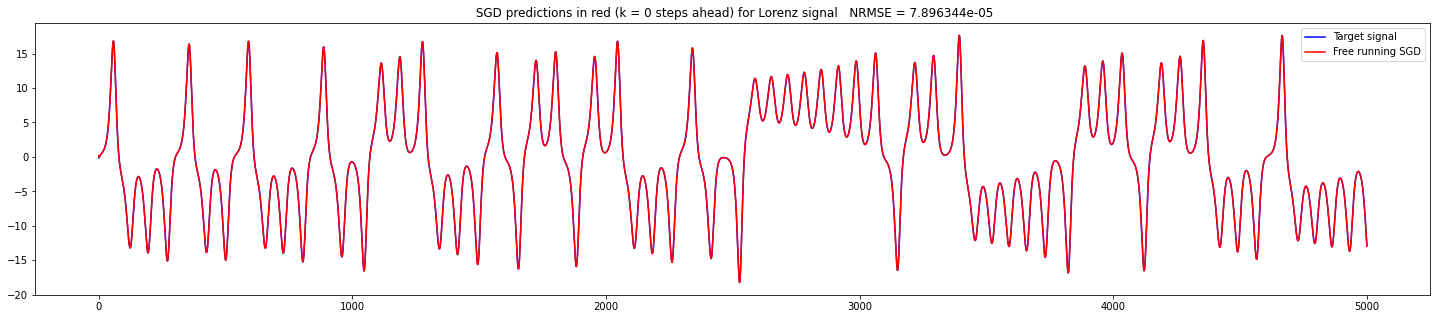

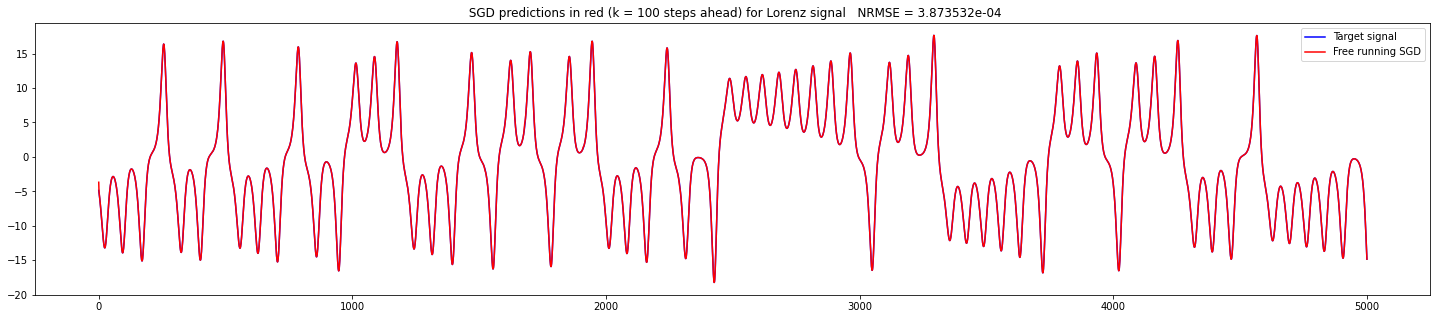

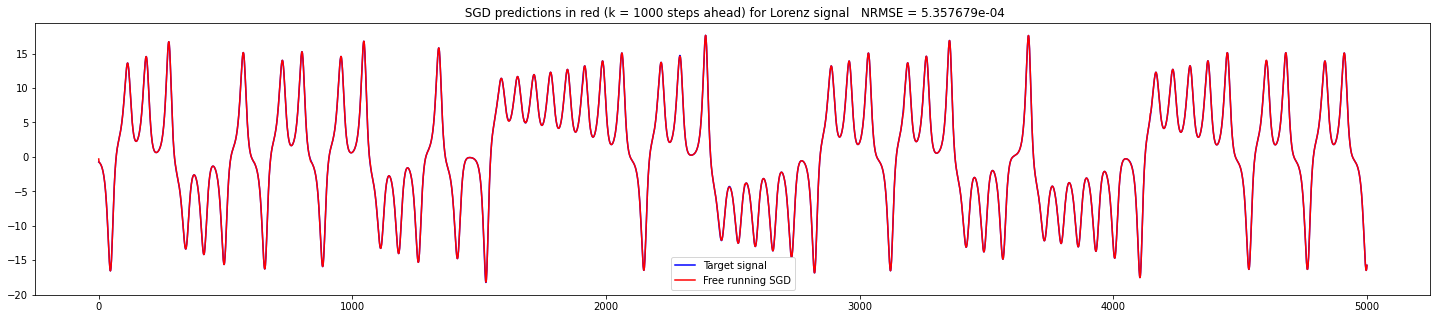

In [14]:
# Visualize the predicted results with original signal
# Plot1
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k0 :train_len + k0 ], 'b')
plt.plot(Y0.T, 'r')
plt.title(' SGD predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' %(k0,nrmse0))
plt.legend(['Target signal', 'Free running SGD'])

# Plot2
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k1 :train_len + k1 ], 'b')
plt.plot(Y1.T, 'r')
plt.title(' SGD predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' %(k1,nrmse1))
plt.legend(['Target signal', 'Free running SGD'])

# Plot3
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k2 :train_len + k2 ], 'b')
plt.plot(Y2.T, 'r')
plt.title(' SGD predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' %(k2,nrmse2))
plt.legend(['Target signal', 'Free running SGD'])

<span style='color:Orange'>**Results description:**</span><br/>
In the experiment of Gradient Descent based ESN on lorenz system, I test **k** equal to 0, 100, 1000 respectively. The whole training (or testing) data length is 5000. As we can observe in these plots, the values of NRMSE are nearly same and well, which show **k** doesn't affect the results much.

- **Experiments on 2sin system using Gradient Decent based ESN model**

In [15]:
# Load the data and Initialize hyper-parameters
data = np.loadtxt('2sin.txt')
init_len = 100
train_len = 1200
Nx = 100
spectualRadius = 0.95
sparsity = 0
Nu = 1
reg = 1e-8
alpha = 0.03
epoch = 50

# Train GD-ESN by  different k step ahead forecasting tasks
k0 = 0
Y0, nrmse0 = online_SGD(data, init_len, train_len, Nu,
                        Nx, k0, alpha, reg, epoch, spectualRadius, sparsity)

k1 = 100
Y1, nrmse1 = online_SGD(data, init_len, train_len, Nu,
                        Nx, k1, alpha, reg, epoch, spectualRadius, sparsity)

k2 = 500
Y2, nrmse2 = online_SGD(data, init_len, train_len, Nu,
                        Nx, k2, alpha, reg, epoch, spectualRadius, sparsity)


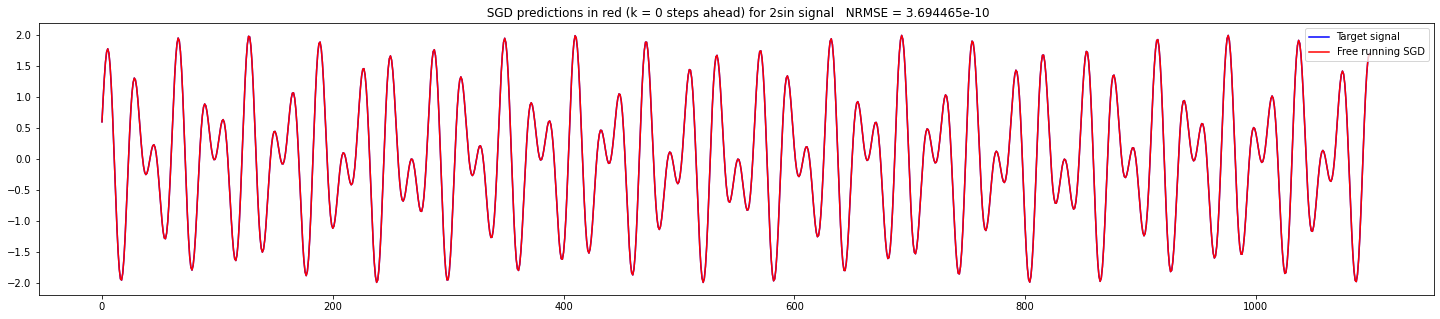

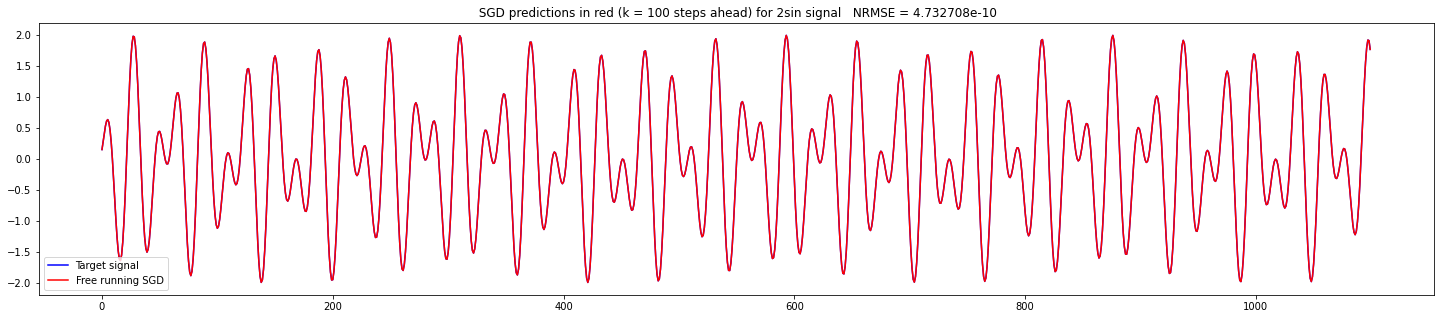

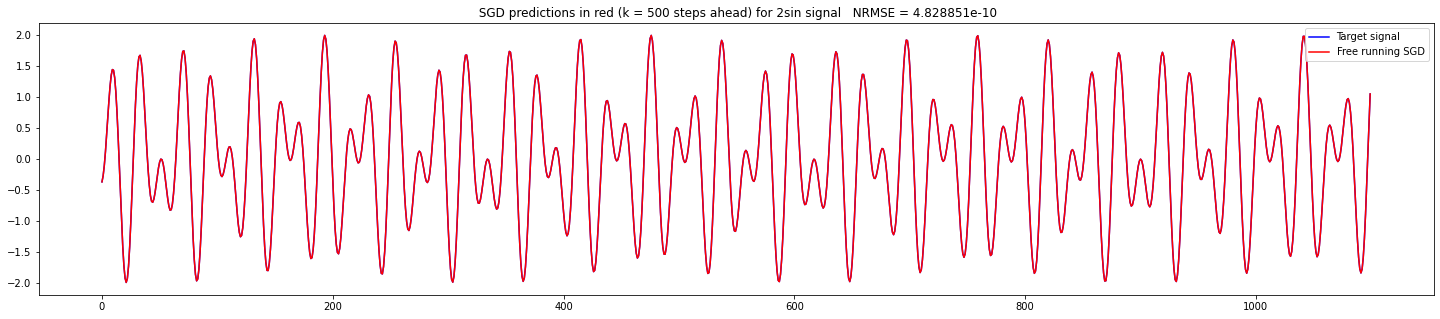

In [16]:
# Visualize the predicted results with original signal
# Plot1
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k0 :train_len + k0 ], 'b')
plt.plot(Y0.T, 'r')
plt.title(' SGD predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k0,nrmse0))
plt.legend(['Target signal', 'Free running SGD'])

# Plot2
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k1 :train_len + k1 ], 'b')
plt.plot(Y1.T, 'r')
plt.title(' SGD predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k1,nrmse1))
plt.legend(['Target signal', 'Free running SGD'])

# Plot3
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k2 :train_len + k2 ], 'b')
plt.plot(Y2.T, 'r')
plt.title(' SGD predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k2,nrmse2))
plt.legend(['Target signal', 'Free running SGD'])

<span style='color:Orange'>**Results description:**</span><br/>
In the experiment of Gradient Descent based ESN on 2sin system, I test **k** equal to 0, 100, 500 respectively, with other hyper-parameters stay the same as the settings of lorenz signal. The results show the robustness to **k**, which they all outperform in the experiments.

<span style='color:Green'>**Analysis and discussion of Part 2:**</span><br/>
* In order to solve the real-time requirements of the online problem, the gradient descent based ESN is implemented. This method is as known as the least mean square (LMS), which belongs to one of the methods of online training. The online learning in Echo State Network can process the generating data and keep adapting the model. In this scenario, the **Wout** here are weights which act as linear combiner and can be optimised by minimizing the loss function of this problem.<br/>In the experiments above, it is clearly that the values of **k** have no significant effect on both Lorenz and 2sin datasets. And the reason for this is quite straightforward. As far as I'm concerned, the <span style='color:Blue'>online_SGD</span> trains and updates the readout weights by gradient decent when each data point comes in. The k-step ahead forecasting tasks won't be greatly affected, because no matter how large the **k** is, the k steps far input point is equivalent for the algorithm as long as they're coming from the consecutive sequence of data. <br/>
* For gradient descent, there're two crucial parameters, the learning rate and the epoch. The adjustments of these two parameters are closely related. In general, the more epochs in the algorithm, the less error the trained network will has. However, if the training contains too many epochs, the ESN model tries to reach zero error where it is starting to learn the noise of training data, which could cause the problem of over-fitting. Besides, considering the amount of calculation and the time to train the network, I choose **epoch**=50 for both data and finetune the learning rates based on this epoch.In the experiments of Lorenz series of part2, I found that the algorithm is extremely sensitive to the learning rate. The problem of exploding gradient will occur when learning rate is larger than 0.0045, in other word, the error gradients are accumulated in large numbers which in turn result in an unstable network. However, if the learning rate is too small, the network will be insufficient and hard to converge in a satisfactory result. Thus, after several trials, I choose **alpha** = 0.004 for lorenz system and **alpha** = 0.03 for 2sin system. Notably, the predictions of 2sin series are surprisingly good, the error computed by NRMSE are nearly equal to 0. 

### Part3: FORCE Learning Algorithm
This section explores the FORCE (First-Order Reduced and Controlled Error) learning algorithm, a powerful online training technique for chaotic neural networks proposed by Sussillo and Abbott (2009). By continuously adjusting the read-out weights in real-time, FORCE learning allows the ESN to achieve stable and robust multi-step forecasts even on challenging datasets. Performance comparisons highlight the advantages or potential limitations of FORCE relative to previous ESN implementations.

The function (<span style='color:Blue'>forceLearning</span>) implement Echo State Network (ESN) that is trained online by means of FORCE learning.

<br/><span style='color:Orange'>**Description:**</span><br/> 
Firstly, ramdomly generate **Win** and **W** matrices by function <span style='color:Blue'>randomWeights</span> defined in part 1, also generate **Wfb** follows by uniform distribution. Initialize **P** as: $$P(0)=\frac{I}{\alpha}\tag{6}$$<br/> 
In the training process, import the corresbonding training data as **u**, and compute the reservoir activation states **x** by the defination of:$$x(n)=tanh(W^{in}u(n)+Wx(n-1)+W^{fb}y^{target}(n-1))\tag{7}$$<br/>Here I use teacher forcing, which is done by feeding the target through feedback connections instead of the real output, in order to break the recurrence.Import **Y_target** with **k** steps ahead as the label of this loop. 
While the iteration is bigger than **init_len**, collect **x** and concatenate it with the input **u** and one bias term in matrix **R**.Next, the prediction **y** is computed by linear regression, then we can get the **error** by subtracting it from the target.
According to the recursive least squares(RLS) in the FORCE learning, the matrix **P** is updated as the rule:$$P(n)=P(n-1)-\frac{P(n-1)R(n)R^{T}(n)P(n-1)}{1+R^{T}(n)P(n-1)R(n)}\tag{8}$$<br/>Similar to the Gradient descent, the weight matrix **Wout** is updated by:$$w^{out}(n+1)=w^{out}(n)-e(n)P(n)R(n)\tag{9}$$ <br/>Return the results, store them into the matrix **Y** , import the new data and keep looping until **n** reaches to **train_len**. Finally caculate the **NRMSE** to evaluate the prediction. 

In [17]:
def forceLearning(data, init_len, train_len, Nu, Nx, k, alpha, spectualRadius, sparsity):
    """
    The function implements Echo State Network (ESN) that is trained online by FORCE learning.

    :param data: the input signal.
    :param init_len: the length of discarded data from the beginning.
    :param train_len: the length of training set including the length of initial transient.
    :param Nu: the input signal dimension and Nx is the number of neurons in the reservoir.
    :param Nx: the number of neurons in the reservoir.
    :param k: k step ahead of the forecasting task.
    :param alpha: the learning rate in gradient decent.
    :param spectualRadius and sparsity are two hyper-parameters which can be tuned to generate a proper reservoir connection matrix W.

    return: predicted results (Y) and NRMSE score.
    """

    Win, W = randomWeights(Nu, Nx, spectualRadius, sparsity)
    np.random.seed(0)
    Wfb = np.random.rand(Nx, 1) - 0.5
    Wout = np.random.rand(1, Nx + Nu + 1) - 0.5
    Y_target = 0
    Y = np.zeros((Nu, train_len-init_len))
    x = np.zeros((Nx, 1))
    P = np.identity(Nx + 2) / alpha

    for n in range(train_len):
        u = data[n]
        x = np.tanh(np.dot(Win, np.vstack((1, u))) +
                    np.dot(W, x) + np.dot(Wfb, Y_target))
        Y_target = data[n+k]
        if n >= init_len:
            R = np.vstack((1, u, x))
            y = np.dot(Wout, R)
            error = y - Y_target
            P = P - (P.dot(R).dot(R.T).dot(P)) / (1+R.T.dot(P).dot(R))
            Wout = Wout - error * np.dot(P, R).T
            Y[:, n-init_len] = y

    t = data[(init_len + k): (train_len + k)]
    diff = t - Y
    nrmse = np.sqrt(diff.dot(diff.T) / len(t)) / np.var(t)

    return Y, nrmse


- **Experiments on Lorenz system using FORCE Learning model**

In [18]:
# Load the data and Initialize hyper-parameters
data = np.loadtxt('lorenz.txt')
init_len = 100
train_len = 10000
Nx = 200
spectualRadius = 0.95
sparsity = 0
Nu = 1
alpha = 1e-5

# Train FORCE Learning by  different k step ahead forecasting tasks
k0 = 0
Y0, nrmse0 = forceLearning(data, init_len, train_len,
                           Nu, Nx, k0, alpha, spectualRadius, sparsity)
k1 = 500
Y1, nrmse1 = forceLearning(data, init_len, train_len,
                           Nu, Nx, k1, alpha, spectualRadius, sparsity)
k2 = 1000
Y2, nrmse2 = forceLearning(data, init_len, train_len,
                           Nu, Nx, k2, alpha, spectualRadius, sparsity)


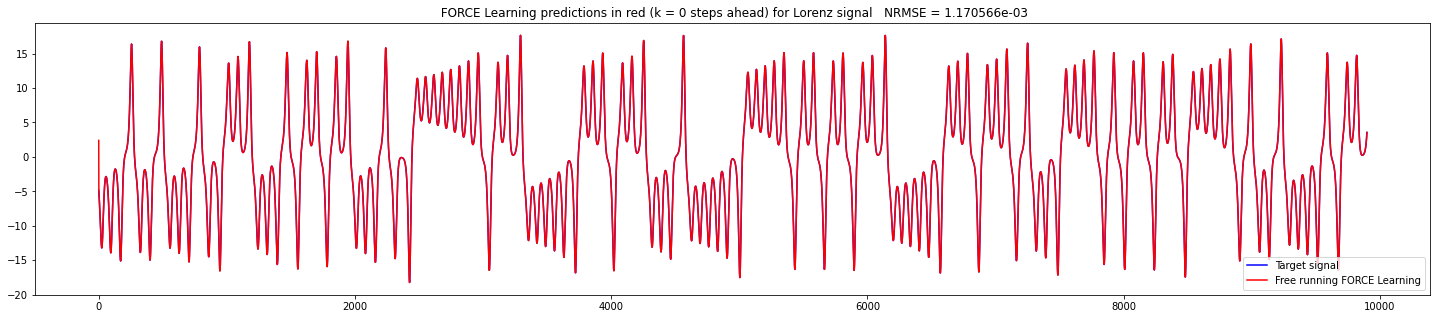

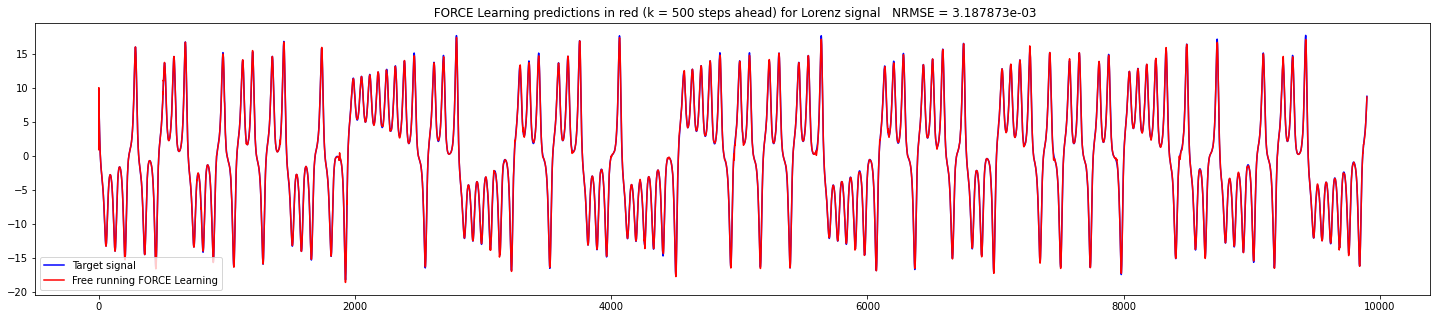

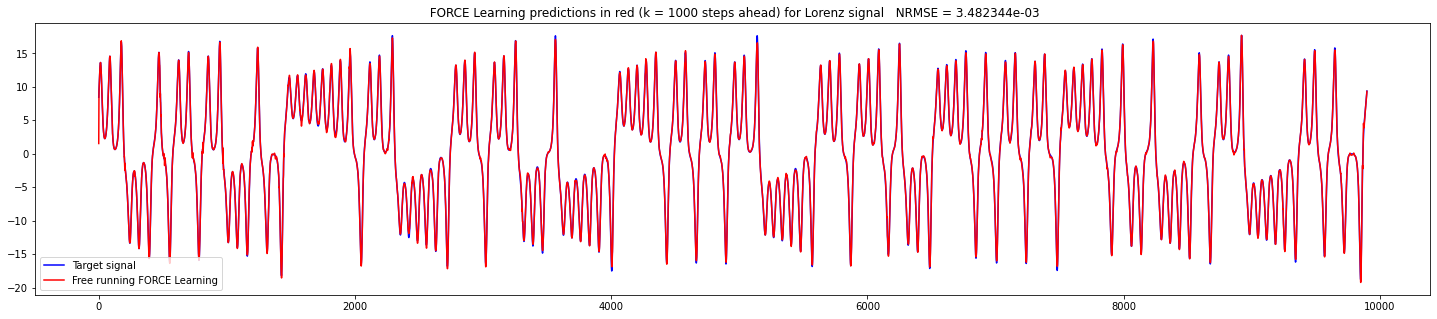

In [19]:
# Visualize the predicted results with original signal
# Plot1
plt.figure(figsize=(25, 5))
plt.plot(data[init_len + k0:train_len + k0], 'b')
plt.plot(Y0.T, 'r')
plt.title(' FORCE Learning predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' % (k0, nrmse0))
plt.legend(['Target signal', 'Free running FORCE Learning'])

# Plot2
plt.figure(figsize=(25, 5))
plt.plot(data[init_len + k1:train_len + k1], 'b')
plt.plot(Y1.T, 'r')
plt.title(' FORCE Learning predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' % (k1, nrmse1))
plt.legend(['Target signal', 'Free running FORCE Learning'])

# Plot3
plt.figure(figsize=(25, 5))
plt.plot(data[init_len + k2:train_len + k2], 'b')
plt.plot(Y2.T, 'r')
plt.title(' FORCE Learning predictions in red (k = %d steps ahead) for Lorenz signal   NRMSE = %e' % (k2, nrmse2))
plt.legend(['Target signal', 'Free running FORCE Learning'])


<span style='color:Orange'>**Results description:**</span><br/>
In the experiment of FORCE learning on lorenz system, I test **k** equal to 0, 500, 1000 respectively. The whole training (or testing) data length is 10000. As we can observe in these plots, the values of NRMSE are nearly same and well, which show **k** doesn't affect the results much. However, at the begining of the series, the predictions are not so well, which lower the NRMSE in a certain extent.

- **Experiments on 2sin system using FORCE Learning model**

In [20]:
data = np.loadtxt('2sin.txt')
init_len = 100
train_len = 1200
Nx = 100
spectualRadius = 0.95
sparsity = 0
Nu = 1
alpha = 1e-5

# Train FORCE Learning by  different k step ahead forecasting tasks
k0 = 0
Y0, nrmse0 = forceLearning(data, init_len, train_len,
                           Nu, Nx, k0, alpha, spectualRadius, sparsity)
k1 = 100
Y1, nrmse1 = forceLearning(data, init_len, train_len,
                           Nu, Nx, k1, alpha, spectualRadius, sparsity)
k2 = 500
Y2, nrmse2 = forceLearning(data, init_len, train_len,
                           Nu, Nx, k2, alpha, spectualRadius, sparsity)


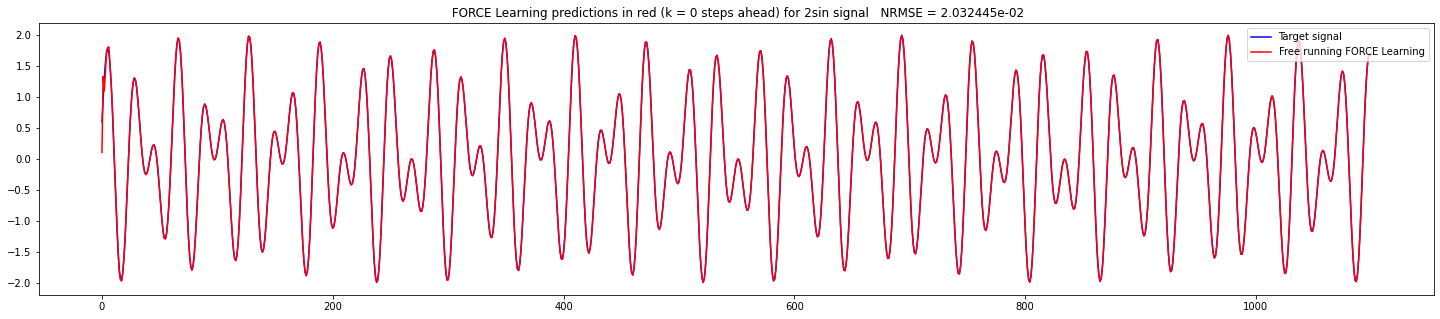

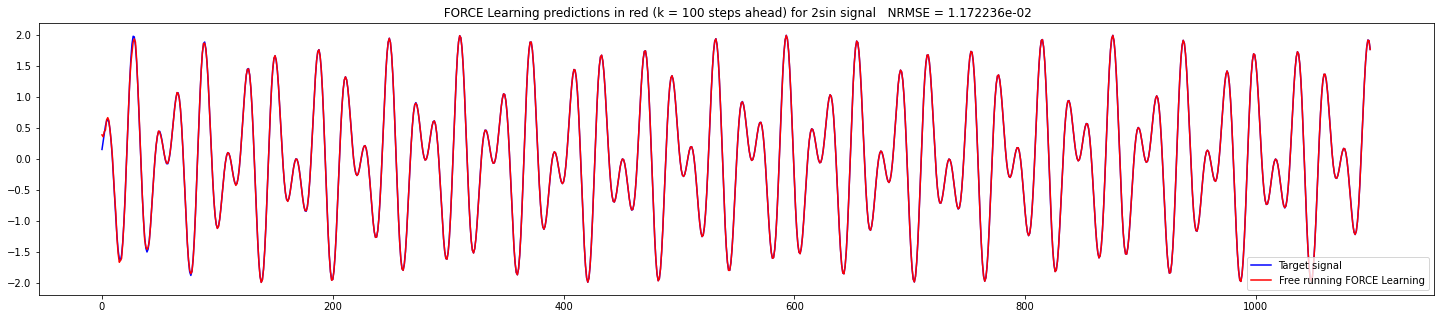

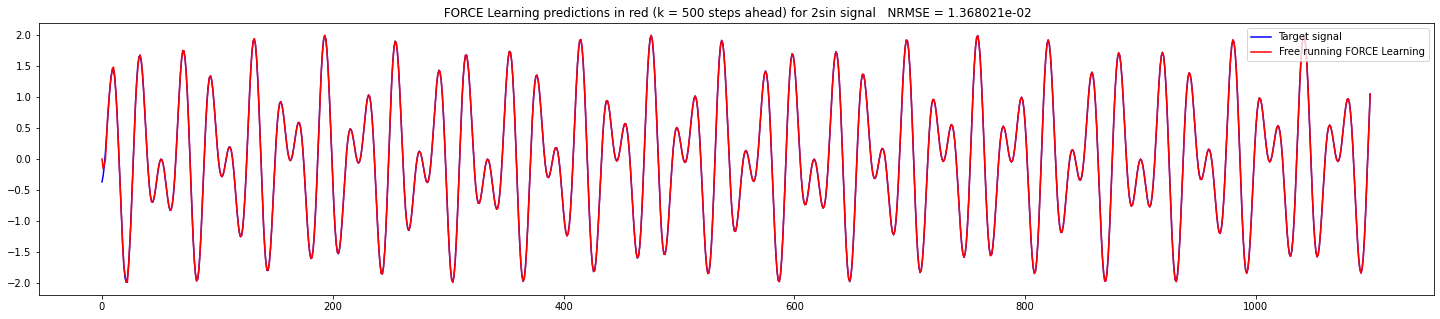

In [21]:
# Visualize the predicted results with original signal
# Plot1
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k0 :train_len + k0 ], 'b')
plt.plot(Y0.T, 'r')
plt.title(' FORCE Learning predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k0,nrmse0))
plt.legend(['Target signal', 'Free running FORCE Learning'])

# Plot2
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k1 :train_len + k1 ], 'b')
plt.plot(Y1.T, 'r')
plt.title(' FORCE Learning predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k1,nrmse1))
plt.legend(['Target signal', 'Free running FORCE Learning'])

# Plot3
plt.figure(figsize=(25,5))
plt.plot(data[init_len + k2 :train_len + k2 ], 'b')
plt.plot(Y2.T, 'r')
plt.title(' FORCE Learning predictions in red (k = %d steps ahead) for 2sin signal   NRMSE = %e' %(k2,nrmse2))
plt.legend(['Target signal', 'Free running FORCE Learning'])

<span style='color:Orange'>**Results description:**</span><br/>
In the experiment of FORCE learning on 2sin system, I test **k** equal to 0, 100, 500 respectively. The whole training (or testing) data length is 1200. As same as all the experiments of 2sin signal, the results show the online learning algorithm is robust to k. Just as the Lorenz signal in Part3, the first few predictions doesn't perform very well.

<span style='color:Green'>**Analysis and discussion of Part 3:**</span><br/>
* In this paper introduced by Sussillo et al., they use the Recursive Least Squares (RLS) algorithm in echo state network. Also, the feedback signal is included during training. First of all, comparing to the basic ESN model in part1, FORCE Learning can handle the generating data and keep adapting the model itself, since it belongs to online learning algorithms. In my trials, I found that output feedbacks are important parts in this model, by adding the feedback term, the trained readouts are fed back to the reservoir and change its dynamics. Moreover, I use teacher forcing in formula (7) to boost and speedup the learning process in the direction of the targets. <br/>
* In FORCE learning, as authors explained in the paper, errors are always small even from the beginning of the training process. As a result, the goal of training is not significant error reduction, but rather reducing the amount of modification needed to keep the errors small. Therefore, look back to the results of my implementation, I guess this is the reason why the first few predictions are reletively worse than the ESN algorithms in part1 & part2. However, as stated in the paper, by the end of the training process, modification is no longer needed, and the network can generate the desired output autonomously. This can be a superiority of FORCE Leaning comparing to other online learning methods like gradient descent based ESN, which need to tune parameters manually depending on different tasks and could be laborious and ineffective. 

